In [90]:
from funcs import *

### FULL DOSE ANALYSIS ###
SAVE_FIGs = False  # set to true if you want to overwrite the figure files.
REWRITE_DF = True
LOAD_DF = False
LOAD_ROIS = True  # set to false if you want to query and load all the rois from scratch.
REWRITE_ROIS = False  # set to true if you want to resave the loaded rois.
tqdm.pandas()

In [91]:
if LOAD_DF:
    ndata_df = pd.read_json('full_data_30032025.json', orient = 'records')
    ndata_df[['e', 'raw', 'hnorm', 'bgd', 'clean']] = ndata_df[['e', 'raw', 'hnorm', 'bgd', 'clean']].map(np.array)
    ndata_df = ndata_df[ndata_df.path.str.contains('roi\d+.txt')]
    ndata_df['roin'] = ndata_df.roin.astype(int).astype(str)

else:
    with open(r"\\isi.storwis.weizmann.ac.il\Labs\dvirg\yonatabr\roi_results_full_rad.pkl", "rb") as resfile, open(
            r"\\isi.storwis.weizmann.ac.il\Labs\dvirg\yonatabr\roi_paths_full_rad.pkl", "rb"
        ) as pathfile, open(r"\\isi.storwis.weizmann.ac.il\Labs\dvirg\yonatabr\roi_energies_full_rad.pkl", "rb") as energyfile:
            roi_results = load(resfile)
            roi_paths = load(pathfile)
            Tens = load(energyfile)

    paths = pd.Series(list(roi_paths) + list(collapse([get_rois(x) for x in [r"\\isi.storwis.weizmann.ac.il\Labs\dvirg\zoharba\ALBA Oct 2022\20221206"] + tilts + raddam + nrad])))

    roi_categories = np.vectorize(lambda x: x + "s" if x == "vesicle" else x)(
        np.array([recede(x.split("proc")[1], dpath=0) for i, x in enumerate(roi_paths)])
    )

    data_df = df(paths, columns = ['path'])

    nroi_categories = [*roi_categories, *paths[len(roi_paths):].apply(lambda x: 'crystals' if 'crystal' in x else 'vesicle')]

    qd = pd.read_csv('nqd30032025.csv').set_axis(axis = 'columns', labels = ['path', 'vals'])

    qd = qd.set_index('path')['vals'].to_dict()

    date_format = '%Y%m%d'
    data_df['date'] = data_df.path.map(lambda x: datetime.datetime.strptime(Path(x).parts[4], date_format))
    data_df['category'] = np.vectorize(
        lambda x: (
            'crystal'
            if x in {"adult", "adult background test", "crystals", "small"}
            else 'vesicle' if "vesicle" in x else 'undefined'
        )
    )(nroi_categories)
    data_df['FOV'] = data_df.path.map(lambda x: Path(x).parent.parent.parent)
    data_df['sample'] = pd.factorize(data_df['FOV'])[0]
    # filter and basic preprocessing
    # data_df = data_df[data_df.category != 'undefined']

    # labeling
    data_df.loc[data_df.date.map(lambda x: x.strftime(date_format)) == '20221206', ['label', 'iter']] = ''
    data_df.loc[data_df.path.str.contains('[Rr]ad'), 'label'] = 'raddam'
    data_df.loc[data_df.path.str.contains('20221206') & ~ data_df.path.str.contains('Rad'), 'label'] = 'tilt'
    data_df.loc[data_df.path.str.contains('tilting'), 'label'] = 'tilt'
    data_df.loc[(data_df.date.dt.year == 2023) & (data_df.label.isna()), 'label'] = 'low_dose'
    data_df.loc[(data_df.date.dt.year == 2022) & (data_df.label.isna()), 'label'] = 'std_dose'
    data_df.loc[data_df.label.isin(['tilt', 'raddam']), 'iter'] = [int(x) if len(x) < 3 else 0 for x in data_df[data_df.label.isin(['tilt', 'raddam'])].path.map(lambda x: re.findall('\d+', x.split('process')[0])[-1])]
    data_df['iter'] = data_df.iter.astype(float)

    data_df.loc[data_df.path.str.contains('[Rr]ad'), 'label'] = 'raddam'
    data_df.loc[data_df.path.str.contains('20221206') & ~ data_df.path.str.contains('Rad'), 'label'] = 'tilt'
    data_df.loc[data_df.path.str.contains('tilting'), 'label'] = 'tilt'

    data_df = data_df[~((data_df.label == 'raddam') & (data_df.date.dt.year == 2023) & (data_df.path.str.contains('_OF')))]
    data_df['roin'] = data_df.path.str.extract('roi(\d+).txt')

    ezs = data_df.path.progress_apply(get_roi_ez)
    ezs = df(ezs.tolist(), columns = ['e', 'raw'])

    ezs['path'] = data_df.path.values

    nqdf = df(pd.Series(qd).astype(int), columns = ['vals']).eval('bad=vals==0').eval('flip=vals<0')

    cezs = ezs.copy()

    ezs = cezs.merge(nqdf.reset_index(names = ['path']), on = 'path', how = 'left')

    ezs.bad.fillna(False, inplace = True)
    ezs.flip.fillna(False, inplace = True)
    # ezs.smooth.fillna(False, inplace = True)

    ezs = ezs[~ezs.bad]

    ezs.loc[ezs.flip, 'raw'] = ezs.loc[ezs.flip, 'raw'] * -1

    # ezs.loc[ezs.smooth, 'raw'] = ezs.loc[ezs.smooth, 'raw'].apply(gfilt, sigma = 1)

    ezs['hnorm'] = ezs.raw.apply(hnorm)
    ezs['bgd'] = ezs.apply(axis = 1, func = lambda x: remove_background_guan(x.e, x.raw)[1])
    ezs['clean'] = ezs.apply(axis = 1, func = lambda x: remove_arctan_guan(x.e, x['bgd'])[1])
    ezs.dropna(subset = 'clean', inplace = True)

    for basis in ('raw', 'bgd', 'clean'):
        ezs[f'left_{basis}'] = ezs.apply(axis = 1, func = lambda x: find_peak(x.e, hnorm(x[basis]), *LEFT_PEAK))
        ezs[f'right_{basis}'] = ezs.apply(axis = 1, func = lambda x: find_peak(x.e, hnorm(x[basis]), *RIGHT_PEAK))
        ezs[f'ratio_{basis}'] = ezs[f'right_{basis}'] / ezs[f'left_{basis}']
        if basis != 'clean':
            ezs[f'sigma_{basis}'] = ezs.apply(axis = 1, func = lambda x: find_peak(x.e, x[basis], *SIGMA_PEAK) if any(x.e > SIGMA_PEAK[0]) else None)


    ndata_df = data_df.merge(ezs, on = 'path')

    ndata_df = ndata_df[ndata_df.category != 'undefined']

100%|████████████████████████████████████████████████████████████████████████████████| 925/925 [02:52<00:00,  5.37it/s]
C:\Users\yonatabr\AppData\Local\Temp\7\ipykernel_72396\2916230312.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ezs.bad.fillna(False, inplace = True)
C:\Users\yonatabr\AppData\Local\Temp\7\ipykernel_72396\2916230312.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

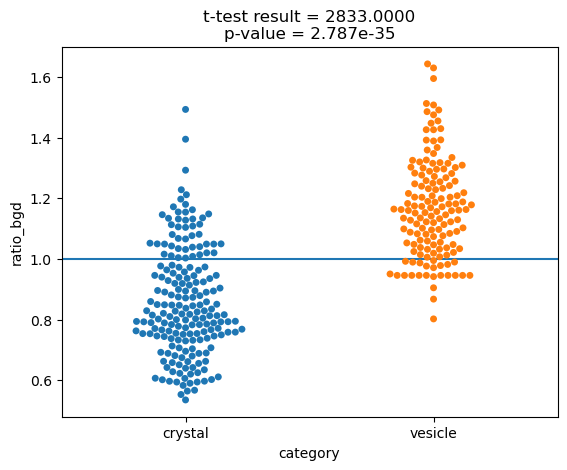

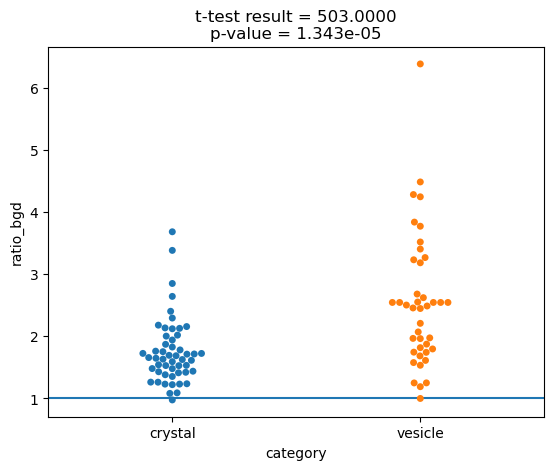

In [292]:
# swarmplot of perepeak ratios, crystlas vs vesicles, first 'standard' dose, then low dose
basis = 'bgd'
for sdose in ('std_dose', 'low_dose'):
    dose = ndata_df[ndata_df.label == sdose]
    sns.swarmplot(dose, x = 'category', y = f'ratio_{basis}', hue = 'category')
    ttest_res = scipy.stats.mannwhitneyu(*dose.groupby('category')[f'ratio_{basis}'].agg(list).values)
    plt.title(f"t-test result = {ttest_res[0]:.4f}\np-value = {ttest_res[1]:.4g}")
    plt.axhline(1)
    plt.show()

<Axes: xlabel='iter', ylabel='new_value'>

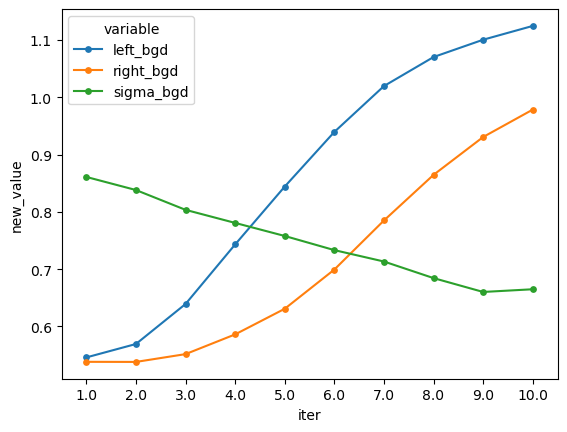

In [293]:
# returns trend of peak parameters of crystals when radiated
basis = "bgd"
rad_df = ndata_df[(ndata_df.date.dt.year == 2022) & (ndata_df.label == "raddam")]
mrad_df = rad_df.melt(id_vars=['iter', 'category'], value_vars=[f'left_{basis}', f'right_{basis}', f'sigma_{basis if basis != "clean" else "bgd"}'])
mrad_df['new_value'] = mrad_df.sort_values(by = 'iter').groupby('variable')['value'].transform(gfilt, sigma = 1)
sns.pointplot(
    data = mrad_df,
    x = 'iter',
    y = 'new_value',
    hue = 'variable',
    linewidth = 1.5,
)

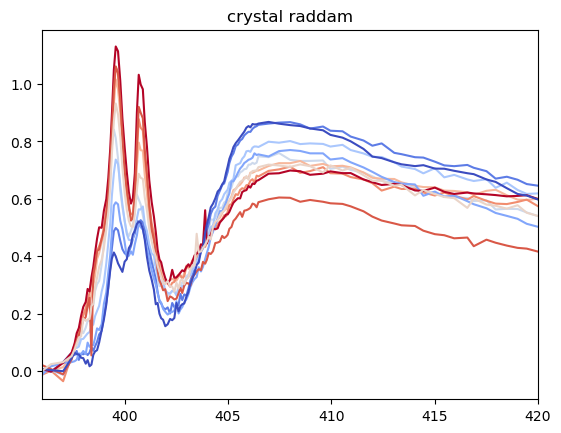

In [334]:
rad_df = ndata_df[(ndata_df.date.dt.year == 2022) & (ndata_df.label == 'raddam')]
color_plots(rad_df.e, rad_df.bgd, rad_df.iter, cm.coolwarm)
plt.title('crystal raddam')
plt.xlim(396, 420)
plt.show()

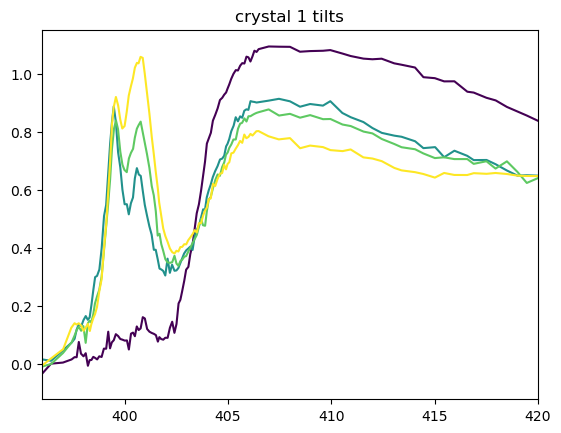

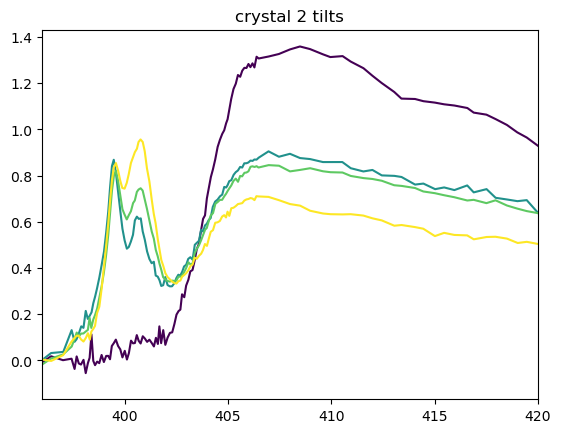

In [294]:
# shows crystals absorption when tilted
tilt_df = ndata_df[(ndata_df.date.dt.year == 2022) & (ndata_df.label == 'tilt')]
for roin, x in tilt_df.groupby('roin'):
    color_plots(x.e, x.bgd, x.iter, cm.viridis)
    plt.title(f'crystal {roin} tilts')
    plt.xlim(396, 420)
    plt.show()

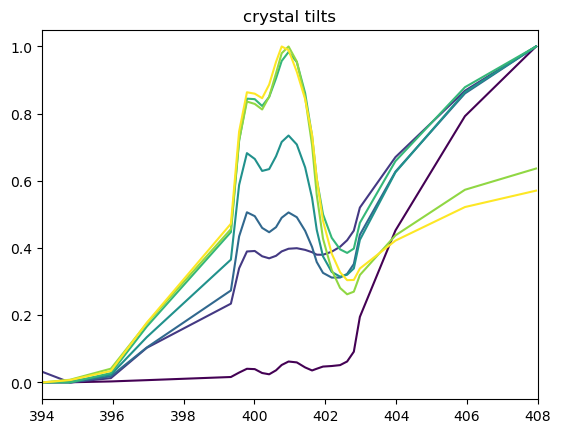

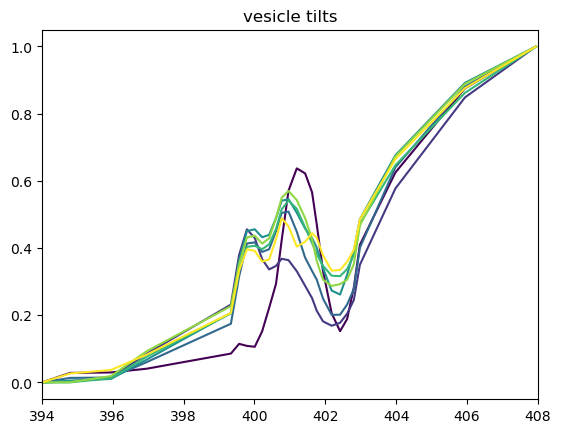

In [295]:
# show crystals and vesicles absorption when tilted, second experiment
basis = 'bgd'
tilt_df = ndata_df[(ndata_df.date.dt.year == 2023) & (ndata_df.label == 'tilt')]
ctilts = tilt_df.groupby(['category', 'iter'])[basis].apply(lambda idf : np.array(idf.apply(hnorm).apply(list).tolist()).mean(0)).reset_index()
for categ, cctilt in ctilts.groupby('category'):
    color_plots([tilt_df.e.iloc[0]]*len(cctilt), cctilt[basis].apply(gfilt, sigma = 1).apply(qnorm), cctilt.iter)
    plt.title(f'{categ} tilts')
    plt.xlim(394, 408)
    plt.show()

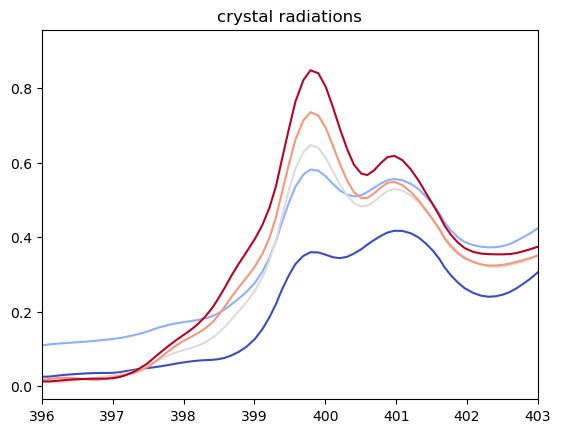

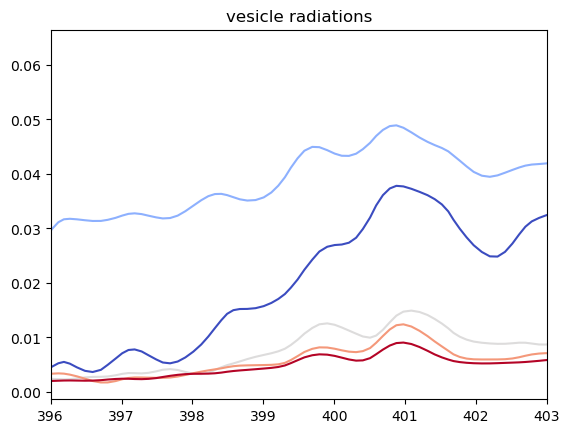

In [313]:
# show example crystals and vesicles absorption when radiated, second experiment
basis = 'bgd'
rad_df = ndata_df[(ndata_df.date.dt.year == 2023) & (ndata_df.label == 'raddam') & (ndata_df.roin == '3')]
crads = rad_df.groupby(['category', 'iter'])[basis].apply(lambda idf : np.array(idf.apply(hnorm).apply(list).tolist()).mean(0)).reset_index()
for categ, ccrad in crads.groupby('category'):
    color_plots([rad_df.e.iloc[0]]*len(ccrad), ccrad[basis].apply(hnorm).apply(gfilt, sigma = 2), ccrad.iter, cm.coolwarm)
    plt.title(f'{categ} radiations')
    plt.xlim(396, 403)
    plt.show()

C:\Users\yonatabr\AppData\Local\Temp\7\ipykernel_73928\657602430.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  radtilt = ndata_df[ndata_df.label.isin(('raddam', 'tilt'))].dropna().groupby(['date', 'roin', 'category', 'label']).apply(lambda x:


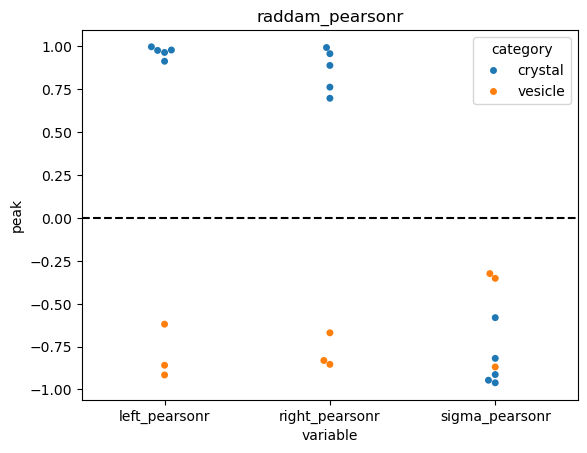

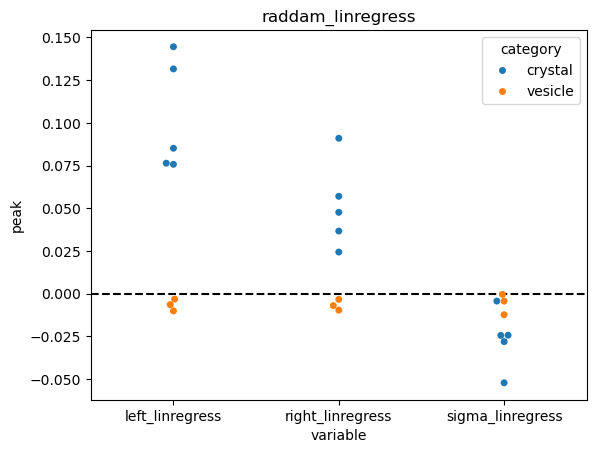

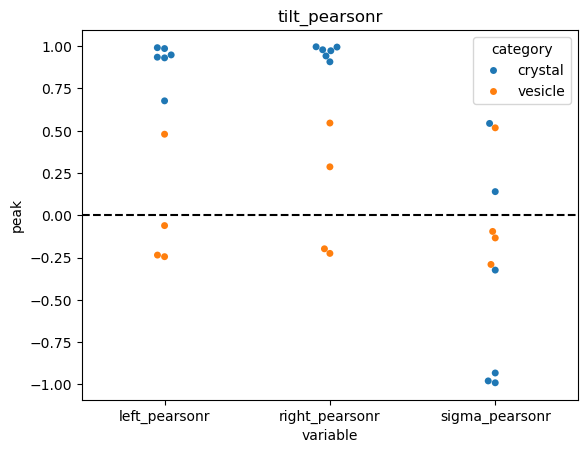

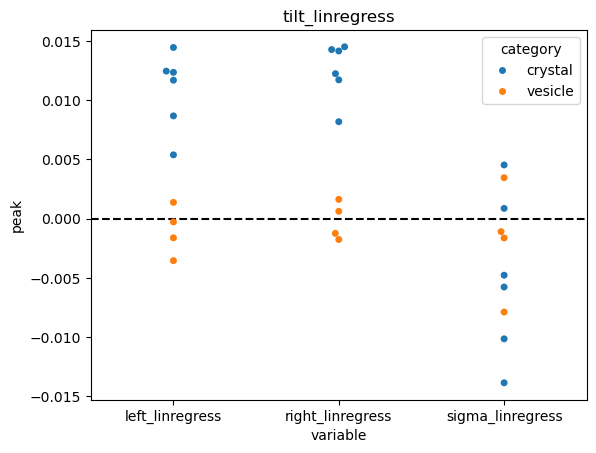

In [314]:
# shows slope and correlation of peak heights when radiated and tilted, for crystals and vesicles, as swarm plots
radtilt = ndata_df[ndata_df.label.isin(('raddam', 'tilt'))].dropna().groupby(['date', 'roin', 'category', 'label']).apply(lambda x: 
    pd.Series({f'{side}_{method.__name__}':getattr(method(x.iter, x[f'{side}_{basis}']), 'statistic' if method == pearsonr else 'slope')
               if len(x) > 2 else None
               for method in (pearsonr, linregress) for side in ('left', 'right', 'sigma')
              })).reset_index().sort_values(by = ['label', 'date', 'roin'])

for label, d in radtilt.query('not (category == "crystal" & label == "tilt" and left_pearsonr < 0)').groupby('label'):
    for method in ('pearsonr', 'linregress'):
        sns.swarmplot(d.melt(value_name='peak', id_vars = ['date', 'roin', 'category'], value_vars=[f'{side}_{method}' for side in ('left', 'right', 'sigma')]), x = 'variable', y = 'peak', hue = 'category')
        plt.title(f'{label}_{method}')
        plt.axhline(0, linestyle = '--', color = 'k')
        plt.show()

In [308]:
# saves dataframe needed for the analysis to shorten reloading
if REWRITE_DF:
    date_format = '{x.day:02d}{x.month:02d}{x.year:04d}'.format(x = datetime.datetime.today())
    sdata_df = ndata_df.copy()
    sdata_df['FOV'] = sdata_df['FOV'].astype(str)
    sdata_df.to_json(f'full_data_{date_format}.json', orient = 'records')

In [329]:
# make violin plot of peak widths for crystals vs vesicles
zohar_columns = ['path', 'date', 'category', 'FOV', 'sample', 'roin', 'label', 'iter', 'left_bgd', 'right_bgd', 'ratio_bgd', 'sigma_bgd', 'left_width', 'right_width']

widths = ndata_df.apply(axis = 1, func = lambda row: np.array(noerror(fit_sppeaks)(row.e, hnorm(gfilt(row.bgd, 1)), ub = (0.8, 404, 1.5)))[:, 2], )

`x0` is infeasible. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. rpopt
`x0` is infeasible. lpopt
`x0` is infeasible. rpopt


C:\Users\yonatabr\AppData\Local\Temp\7\ipykernel_73928\894099586.py:146: OptimizeWarning: Covariance of the parameters could not be estimated
  lpopt, _ = curve_fit(


`x0` is infeasible. rpopt
`x0` is infeasible. rpopt
`x0` is infeasible. rpopt
Optimal parameters not found: The maximum number of function evaluations is exceeded. lpopt
Optimal parameters not found: The maximum number of function evaluations is exceeded. lpopt
`x0` is infeasible. rpopt
`x0` is infeasible. rpopt


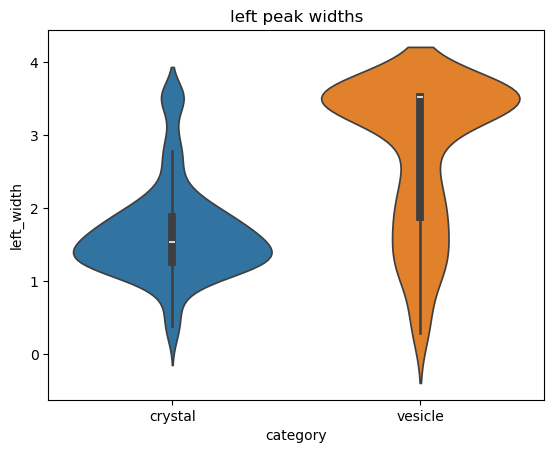

<Axes: title={'center': 'right peak widths'}, xlabel='category', ylabel='right_width'>

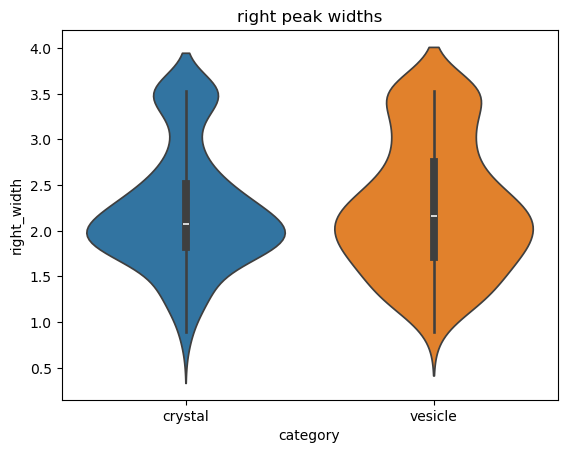

In [331]:
ndata_df[['left_width', 'right_width']] = fwhm(np.array(widths.tolist()))

sns.violinplot(ndata_df.loc[:, zohar_columns], x = 'category', y = 'left_width', hue = 'category')
plt.title('left peak widths')
plt.show()
plt.title('right peak widths')
sns.violinplot(ndata_df.loc[:, zohar_columns], x = 'category', y = 'right_width', hue = 'category')

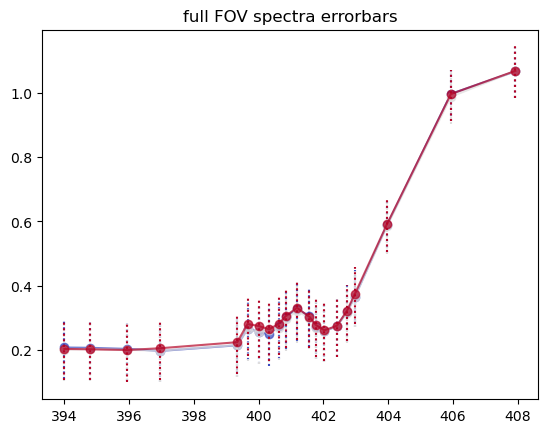

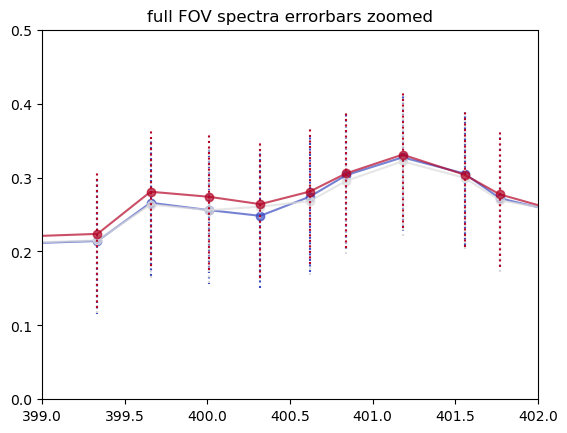

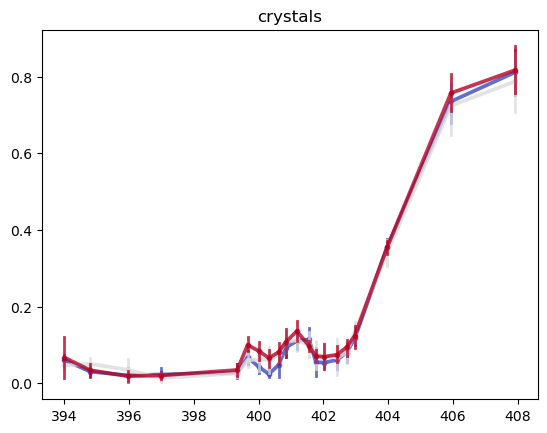

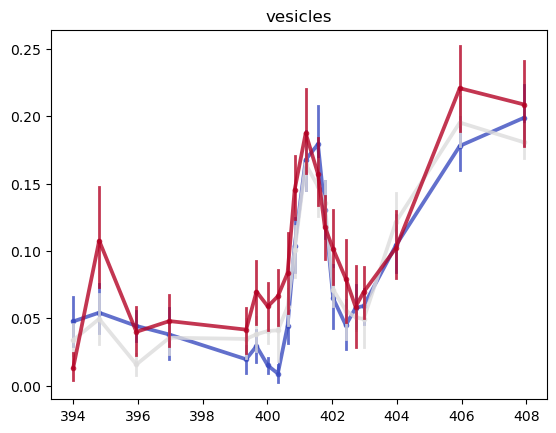

In [518]:
# low dosage screens to show minimal effect on results of vesicles and crystals
# loading and preprocessing
mosaic_directory = Path(
    r"\\isi.storwis.weizmann.ac.il\Labs\dvirg\zoharba\ALBA May 2023\20230524\ALBA25_G4_72hpf\mosaic11"
)
mosaic_dirs = LS(mosaic_directory, 1, 1)
roi_paths = [
    x for x in (mosaic_directory.glob("**/roi*.txt")) if "RoiSet" not in str(x)
]
e, z = np.array([get_roi_ez(path) for path in roi_paths]).transpose(1, 0, 2)
e = e[0]
z = np.array([-zi for zi in z])
z = (z.T - z.min(1)).T
zs = list(z)
labs = np.array([Path(x).parent.name for x in roi_paths])
roin = [int(re.search("roi(\d+).txt", str(path)).groups()[0]) for path in roi_paths]
rad = [int(re.search("Escan(\d)?", str(path)).groups()[0] or 1) for path in roi_paths]
roi_df = df(
    ([e] * len(zs), zs, labs, roin, rad), index=["es", "zs", "crysves", "roin", "rad"]
).T


# rois of all vesicles over radiation
all_conds = lambda z: reduce(
    lambda x, y: x * y, z
)  # function to make intersection of 1 or more conditions

# make FoV (Field of View) data and error bars data
stats = []
error_range = 0.2  # define error range for error bars
for i in range(3):
    stack = (
        tif_stack(str(mosaic_dirs[i] / "serie" / "cropped" / "BC_cropped_filt")) * -1
    )
    mask = np.apply_along_axis(
        lambda x: not any(np.abs(x)), 0, stack
    )  # mask pixels with no values over the whole stack
    stack[:, mask] = np.nan
    flat_stack = stack.copy()
    flat_stack = flat_stack.reshape(
        flat_stack.shape[0], flat_stack.shape[1] * flat_stack.shape[2]
    )
    flat_stack[flat_stack == 0] = np.nan
    mins = np.nanquantile(flat_stack, 0.5 - error_range, axis=1)
    minn = mins.min()
    mins -= minn
    maxs = np.nanquantile(flat_stack, 0.5 + error_range, axis=1) - minn
    means = np.nanquantile(flat_stack, 0.5, axis=1) - minn
    stats.append([means, (mins + means) / 2, (maxs + means) / 2])
stats = np.array(stats)


# FoV plot with error bars
cs = cm.coolwarm(qnorm([0, 1, 2]))
for j in range(3):
    [
        plt.plot([ee, ee], [mn, mx], c=cs[j], linestyle=":")
        for ee, mn, mx in zip(e, *stats[j, 1:])
    ]
    plt.plot(e, stats[j, 0], "-o", c=cs[j], alpha=0.7)
plt.title('full FOV spectra errorbars')
# plt.xlim(399, 402)
# plt.ylim(0.0, 0.5)
# if SAVE:
#     plt.savefig("noradiation FoV full spectrum.pdf")
plt.show()
for j in range(3):
    [
        plt.plot([ee, ee], [mn, mx], c=cs[j], linestyle=":")
        for ee, mn, mx in zip(e, *stats[j, 1:])
    ]
    plt.plot(e, stats[j, 0], "-o", c=cs[j], alpha=0.7)
    
fig = plt.gcf()
plt.xlim(399, 402)
plt.ylim(0.0, 0.5)
plt.title('full FOV spectra errorbars zoomed')
# if SAVE:
#     plt.savefig("noradiation FoV peaks zoom.pdf")
plt.show()


# plot all crystals or vesicles ROIS with their CI error bars
for cv in ("crystals", "vesicles"):
    xydfs = [
        df(
            l2r(
                roi_df.zs[
                    (roi_df.crysves == cv) & (roi_df.rad == i)# & (roi_df.roin > 2)
                ]
            ),
            columns=roi_df.es.values[0].round(2),
        )
        for i in range(1, 4)
    ]
    [
        sns.pointplot(
            xydfs[i].astype(float),
            errorbar=("ci", 95),
            color=cm.coolwarm(i / 2),
            native_scale=True,
            err_kws={"linewidth": 2},
            markersize=2,
            alpha=0.8,
        )
        for i in range(3)
    ]
    plt.title(cv)
#     if SAVE:
#         plt.savefig(f"noradiation {cv} rois.pdf")
    plt.show()

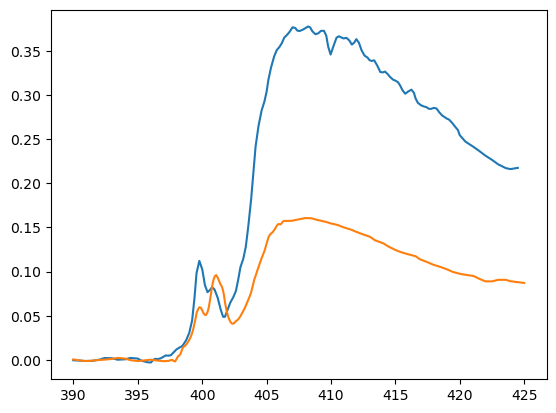

In [148]:
samp_paths = {
    'crystal': '\\\\isi.storwis.weizmann.ac.il\\Labs\\dvirg\\zoharba\\ALBA Oct 2022\\20221026\\Alba22_2_72hpf\\Escan\\Escan_tomo1\\process1\\small\\roi5.txt',
    'vesicle': '\\\\isi.storwis.weizmann.ac.il\\Labs\\dvirg\\zoharba\\ALBA Oct 2022\\20221027\\Alba47_1_48hpf\\Escan\\Escan_tomo10\\process\\vesicles\\roi2.txt'
}
for cv, path in samp_paths.items():
    cryssamp = ndata_df[ndata_df.path == path].iloc[0]
    plt.plot(cryssamp.e, gfilt(cryssamp.bgd, 1), label = cv)

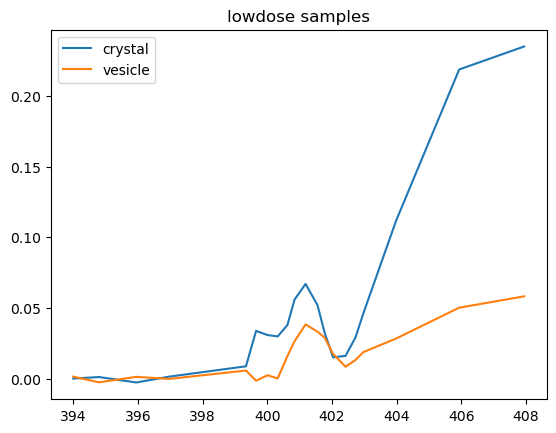

In [140]:
lowdose_paths = {
    'crystal': '\\\\isi.storwis.weizmann.ac.il\\Labs\\dvirg\\zoharba\\ALBA May 2023\\20230525\\ALBA33_G4_72hpf\\Escan\\serieOF_tomo08\\process\\crystals\\roi6.txt',
    'vesicle': '\\\\isi.storwis.weizmann.ac.il\\Labs\\dvirg\\zoharba\\ALBA May 2023\\20230525\\ALBA33_G4_72hpf\\Escan\\serieOF_tomo08\\process\\vesicles\\roi3.txt'
}
for cv, path in lowdose_paths.items():
    samp = ndata_df[ndata_df.path == path].iloc[0]
    plt.plot(samp.e, samp.bgd, label = cv)
plt.title('lowdose samples')
plt.legend()